## Data Import (Bronze Layer)

#### Import Libraries and Setup MongoDB Connection

In [1]:
import pandas as pd
from pymongo import MongoClient

data = pd.read_csv("caso_full.csv")
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['big_data_project']
collection = db['caso_full']

# Import data into MongoDB
data.reset_index(inplace=True) 
records = data.to_dict("records") 
collection.insert_many(records)

print("Row count in MongoDB collection:", collection.count_documents({}))

Row count in MongoDB collection: 1048575


## Data Cleaning (Silver Layer)

#### Handle Null Values and Format Cleaning

In [2]:
data.isnull().sum()

index                                                0
city                                              6619
city_ibge_code                                    4157
date                                                 0
epidemiological_week                                 0
estimated_population                              4157
estimated_population_2019                         4157
is_last                                              0
is_repeated                                          0
last_available_confirmed                             0
last_available_confirmed_per_100k_inhabitants    19645
last_available_date                                  0
last_available_death_rate                            0
last_available_deaths                                0
order_for_place                                      0
place_type                                           0
state                                                0
new_confirmed                                        0
new_deaths

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column                                         Non-Null Count    Dtype  
---  ------                                         --------------    -----  
 0   index                                          1048575 non-null  int64  
 1   city                                           1041956 non-null  object 
 2   city_ibge_code                                 1044418 non-null  float64
 3   date                                           1048575 non-null  object 
 4   epidemiological_week                           1048575 non-null  int64  
 5   estimated_population                           1044418 non-null  float64
 6   estimated_population_2019                      1044418 non-null  float64
 7   is_last                                        1048575 non-null  bool   
 8   is_repeated                                    1048575 non-null  bool   
 9   last_available_confirmed

In [24]:
data['city_ibge_code'] = data['city_ibge_code'].fillna(data['city_ibge_code'].mean())
data['estimated_population'] = data['estimated_population'].fillna(data['estimated_population'].mean())
data['estimated_population_2019'] = data['estimated_population_2019'].fillna(data['estimated_population_2019'].mean())
data['last_available_confirmed_per_100k_inhabitants'] = data['last_available_confirmed_per_100k_inhabitants'].fillna(
    data['last_available_confirmed_per_100k_inhabitants'].mean()
)

# String Columns: Fill with mode
data['city'] = data['city'].fillna(data['city'].mode()[0])

# Date Columns: Convert to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['last_available_date'] = pd.to_datetime(data['last_available_date'], errors='coerce')

# Double-check and clean other potential categorical columns
data['place_type'] = data['place_type'].fillna(data['place_type'].mode()[0])

print("Data cleaning completed.")

Data cleaning completed.


In [5]:
from bson import ObjectId
from datetime import datetime

# Creating a pipeline to find and update the 'date' field
pipeline = [
    {"$set": {"date": {"$toDate": "$date"}}}
]

# Use MongoDB's aggregate with $merge for in-place updates
collection.aggregate([
    *pipeline,
    {"$merge": {"into": "caso_full"}}
])

Date fields converted to ISODate format.


In [20]:
#Checking null values after data cleaning
data.isnull().sum()

index                                            0
city                                             0
city_ibge_code                                   0
date                                             0
epidemiological_week                             0
estimated_population                             0
estimated_population_2019                        0
is_last                                          0
is_repeated                                      0
last_available_confirmed                         0
last_available_confirmed_per_100k_inhabitants    0
last_available_date                              0
last_available_death_rate                        0
last_available_deaths                            0
order_for_place                                  0
place_type                                       0
state                                            0
new_confirmed                                    0
new_deaths                                       0
dtype: int64

## Data Aggregation (Gold Layer)

In [6]:
#Total Confirmed Cases and Deaths by State
pipeline = [
    {"$group": {
        "_id": "$state",
        "total_confirmed": {"$sum": "$last_available_confirmed"},
        "total_deaths": {"$sum": "$last_available_deaths"}
    }},
    {"$sort": {"total_confirmed": -1}}
]

results = list(collection.aggregate(pipeline))
print("Total confirmed cases and deaths by state:")
for result in results:
    print(result)


Total confirmed cases and deaths by state:
{'_id': 'SP', 'total_confirmed': 230711284, 'total_deaths': 9138721}
{'_id': 'BA', 'total_confirmed': 70558943, 'total_deaths': 1544048}
{'_id': 'RJ', 'total_confirmed': 67842116, 'total_deaths': 5069752}
{'_id': 'CE', 'total_confirmed': 64778803, 'total_deaths': 2682594}
{'_id': 'MG', 'total_confirmed': 62979429, 'total_deaths': 1541420}
{'_id': 'PA', 'total_confirmed': 59398277, 'total_deaths': 2017689}
{'_id': 'MA', 'total_confirmed': 45286215, 'total_deaths': 1054296}
{'_id': 'SC', 'total_confirmed': 44992897, 'total_deaths': 583207}
{'_id': 'DF', 'total_confirmed': 43968496, 'total_deaths': 702794}
{'_id': 'GO', 'total_confirmed': 41440211, 'total_deaths': 948532}
{'_id': 'RS', 'total_confirmed': 39867586, 'total_deaths': 996241}
{'_id': 'AM', 'total_confirmed': 38391745, 'total_deaths': 1264402}
{'_id': 'PE', 'total_confirmed': 37827481, 'total_deaths': 2360271}
{'_id': 'PR', 'total_confirmed': 37456497, 'total_deaths': 944191}
{'_id': '

In [7]:
#Weekly Trends in New Confirmed Cases and Deaths
pipeline = [
    {"$group": {
        "_id": "$epidemiological_week",
        "weekly_new_confirmed": {"$sum": "$new_confirmed"},
        "weekly_new_deaths": {"$sum": "$new_deaths"}
    }},
    {"$sort": {"_id": 1}}
]

weekly_trends = list(collection.aggregate(pipeline))
print("Weekly trends in new cases and deaths:")
for trend in weekly_trends:
    print(trend)


Weekly trends in new cases and deaths:
{'_id': 9, 'weekly_new_confirmed': 4, 'weekly_new_deaths': 0}
{'_id': 10, 'weekly_new_confirmed': 33, 'weekly_new_deaths': 0}
{'_id': 11, 'weekly_new_confirmed': 231, 'weekly_new_deaths': 0}
{'_id': 12, 'weekly_new_confirmed': 1935, 'weekly_new_deaths': 30}
{'_id': 13, 'weekly_new_confirmed': 5476, 'weekly_new_deaths': 183}
{'_id': 14, 'weekly_new_confirmed': 13044, 'weekly_new_deaths': 675}
{'_id': 15, 'weekly_new_confirmed': 21260, 'weekly_new_deaths': 1394}
{'_id': 16, 'weekly_new_confirmed': 32365, 'weekly_new_deaths': 2468}
{'_id': 17, 'weekly_new_confirmed': 44664, 'weekly_new_deaths': 3398}
{'_id': 18, 'weekly_new_confirmed': 75848, 'weekly_new_deaths': 5468}
{'_id': 19, 'weekly_new_confirmed': 119621, 'weekly_new_deaths': 7776}
{'_id': 20, 'weekly_new_confirmed': 154869, 'weekly_new_deaths': 10011}
{'_id': 21, 'weekly_new_confirmed': 233772, 'weekly_new_deaths': 12987}
{'_id': 22, 'weekly_new_confirmed': 302704, 'weekly_new_deaths': 13400}

In [8]:
#Death Rate Analysis by Place Type
pipeline = [
    {"$group": {
        "_id": "$place_type",
        "average_death_rate": {"$avg": "$last_available_death_rate"}
    }},
    {"$sort": {"average_death_rate": -1}}
]

place_type_analysis = list(collection.aggregate(pipeline))
print("Death rate analysis by place type:")
for analysis in place_type_analysis:
    print(analysis)


Death rate analysis by place type:
{'_id': 'city', 'average_death_rate': 0.03490398625277843}
{'_id': 'state', 'average_death_rate': 0.03140125396585587}


## Visualizations

### Time-series Chart for Weekly Trends

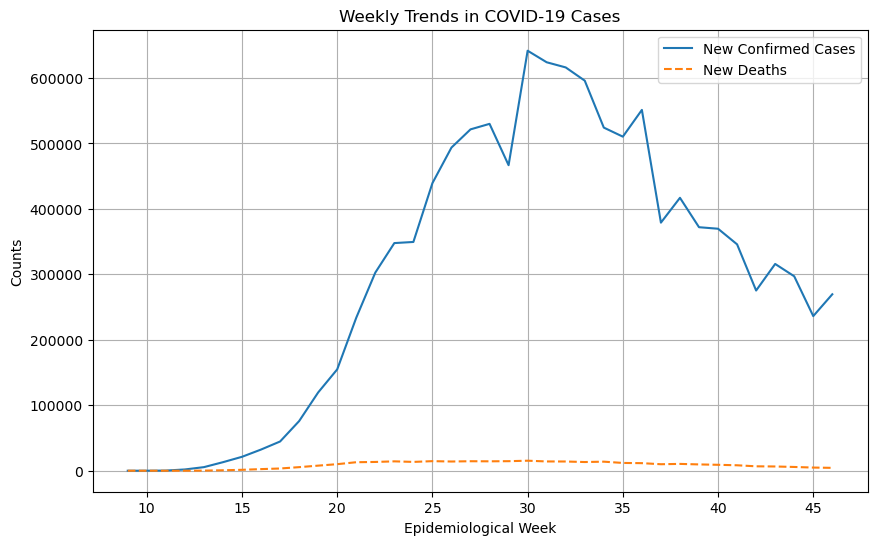

In [11]:
import matplotlib.pyplot as plt
weekly_df = pd.DataFrame(weekly_trends)

# Time-series Chart for Weekly Trends
plt.figure(figsize=(10, 6))
plt.plot(weekly_df["_id"], weekly_df["weekly_new_confirmed"], label="New Confirmed Cases")
plt.plot(weekly_df["_id"], weekly_df["weekly_new_deaths"], label="New Deaths", linestyle="--")
plt.title("Weekly Trends in COVID-19 Cases")
plt.xlabel("Epidemiological Week")
plt.ylabel("Counts")
plt.legend()
plt.grid()
plt.show()

### Bar Chart for Top 10 States by Death Rate

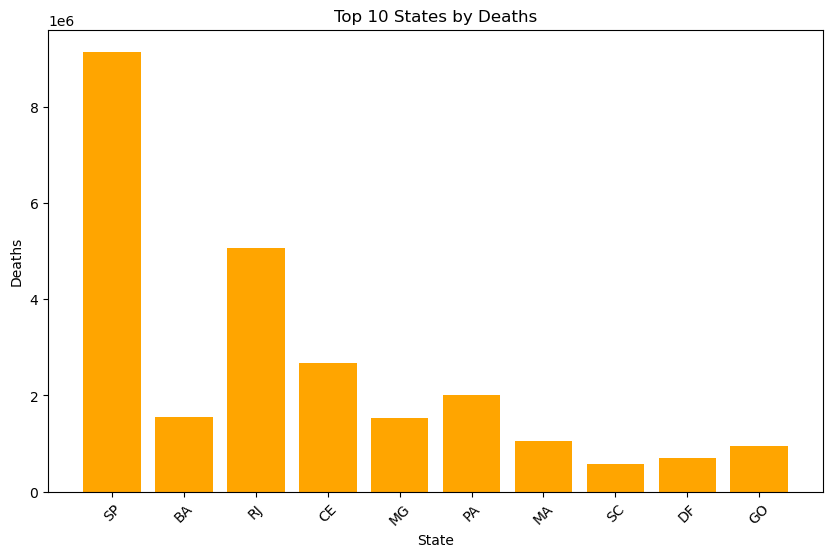

In [12]:
# Bar Chart for Top 10 States by Death Rate
state_df = pd.DataFrame(results).head(10)
plt.figure(figsize=(10, 6))
plt.bar(state_df["_id"], state_df["total_deaths"], color='orange')
plt.title("Top 10 States by Deaths")
plt.xlabel("State")
plt.ylabel("Deaths")
plt.xticks(rotation=45)
plt.show()

### Heatmap: Weekly new confirmed cases across states.

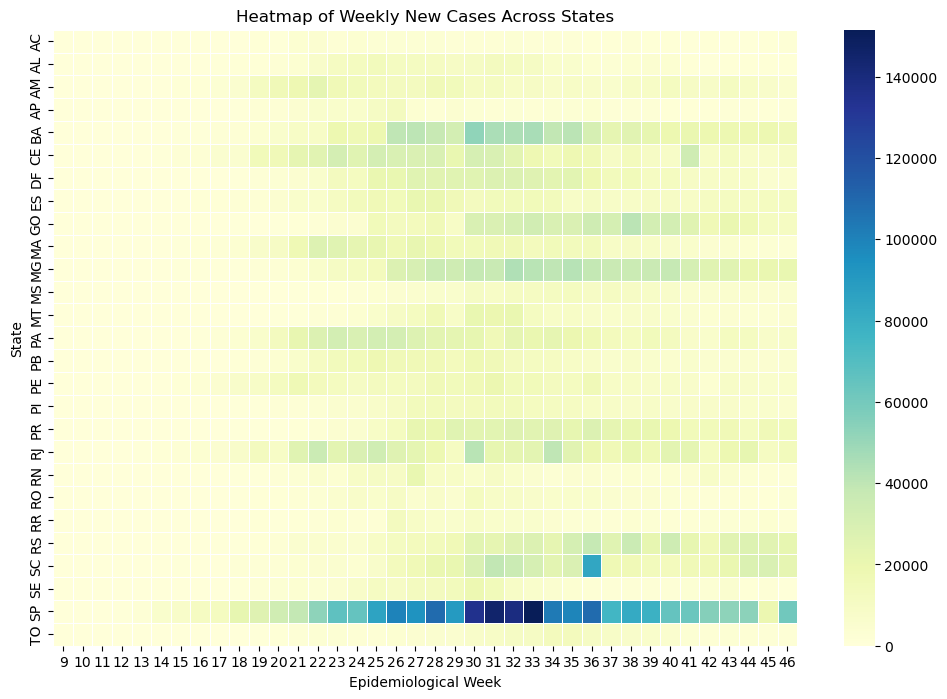

In [10]:
import seaborn as sns
import numpy as np

heatmap_pipeline = [
    {"$group": {
        "_id": {"state": "$state", "week": "$epidemiological_week"},
        "weekly_new_confirmed": {"$sum": "$new_confirmed"}
    }},
    {"$project": {
        "state": "$_id.state",
        "week": "$_id.week",
        "weekly_new_confirmed": 1,
        "_id": 0
    }},
    {"$sort": {"state": 1, "week": 1}}
]

heatmap_data = list(collection.aggregate(heatmap_pipeline))
heatmap_df = pd.DataFrame(heatmap_data)

# Pivot data for heatmap
heatmap_pivot = heatmap_df.pivot(index="state", columns="week", values="weekly_new_confirmed")
heatmap_pivot = heatmap_pivot.fillna(0) 

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, cmap="YlGnBu", linewidths=0.5)
plt.title("Heatmap of Weekly New Cases Across States")
plt.xlabel("Epidemiological Week")
plt.ylabel("State")
plt.show()